In [1]:
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt

# Show all pandas rows/cols:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 100)

# Wide display:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import data_prep as dp
import data_analysis as da
#importlib.reload(dp)
#importlib.reload(da)

# Used functions:

In [2]:
def freq_compare_with_Bible(df, who='TEXT_NAME', name='The Apocryphon of John', words_dict=None):
    """Gets word frequency for the Bible (without the text, if the text is in the Bible),
    Gets word freq for the text,
    Returns log of the mean absolute word freq difference of the two texts
    
    if the word_dict is not passed it will be created (takes a few minutes, so better create it and pass it)
    """
    # - Word dict on all possible words:
    if words_dict is None:
        print('- Getting word dict...')
        words_dict = da.get_words_dict(list(df['sentence']))
    # - Bible df:
    bdf_cond = (df['LIBRARY'].isin(['OT', 'NT']))&(df[who]!=name)
    bdf = df.loc[bdf_cond]
    # - Text df:
    tdf = df.loc[df[who]==name]
    # - Freq comparison:
    #print(f'- Calculating log mean abs freq diff for [{name}]...')
    freq_diff = da.get_mean_freq_diff(list(bdf['sentence']), list(tdf['sentence']), words_dict)
    freq_diff = np.log(freq_diff)
    return freq_diff

def plot_who_vs_LMAWFD(results, df, who = 'AUTHOR'):
    results_agr = results.groupby(who).agg({'LMAWFD': 'mean'}).reset_index().sort_values('LMAWFD', ascending=False).reset_index(drop=True)
    
    # - Data:
    X1 = results_agr['LMAWFD']
    if who == 'AUTHOR':
        # Y1 from 'AUTHOR' -> 'AUTHOR, LIBRAY' as well
        Y1 = results_agr[who]
        for i in range(len(Y1)):
            Y1[i] = Y1[i] + ', ' + df.loc[df['AUTHOR']==Y1[i]]['LIBRARY'].unique()[0]
    else:
        Y1 = results_agr[who]

    # - Figure size:
    fig = plt.figure(figsize=(35,15))

    # - Plot 1:
    #plt.scatter(X1, Y1, color = 'blue')
    colors1 = np.array([0, 10, 20, 30])
    plt.scatter(X1, Y1, c='red', marker='x', s=200) #, cmap='viridis')
    #plt.colorbar() # show the colorbar

    # - Labels and Title:
    font1 = {'family':'serif','color':'black','size':25}
    font2 = {'family':'serif','color':'darkred','size':25}
    plt.title("X vs Y plot", fontdict = font1, 
              loc = 'left' # def=center
             )
    plt.xlabel("Log Mean Abs Word Freq Diff", fontdict = font2)
    plt.ylabel(f"{who}", fontdict = font2)

    # - Grid:
    #plt.grid() # add grid on both axis
    plt.grid(
        axis = 'y', # def=both
        color = 'blue', # specify the grid color
        linestyle = '--', # specify the grid style
        linewidth = 1
            )

    plt.show()
    
def freq_compare_with_Bible_loop(texts='all'):
    #texts: all, Bible/Control
    if texts == 'all':
        # - All texts:
        print('Comparing all texts...')
        texts = list(df.loc[df['LIBRARY'].isin(['OT','NT','NH','Control'])]['TEXT_NAME'].unique())
    else:
        # - Bible vs control:
        print('Comparing Bible (OT,NT) with Control texts only (no NH)...')
        texts = list(df.loc[df['LIBRARY'].isin(['OT','NT','Control'])]['TEXT_NAME'].unique())
    results = {}
    LIBRARYs = []
    AUTHORs = []
    TRANSLATIONs = []
    AUTHOR_LIBRARYs = []
    for text in texts:
        LIBRARYs.append(df.loc[df['TEXT_NAME']==text]['LIBRARY'].unique()[0])
        AUTHORs.append(df.loc[df['TEXT_NAME']==text]['AUTHOR'].unique()[0])
        TRANSLATIONs.append(df.loc[df['TEXT_NAME']==text]['TRANSLATION'].unique()[0])
        AUTHOR_LIBRARYs.append(df.loc[df['TEXT_NAME']==text]['AUTHOR_LIBRARY'].unique()[0])
        results[text] = freq_compare_with_Bible(df, who='TEXT_NAME', name=text, words_dict=words_dict)
    results = pd.DataFrame({
        'TEXT': results.keys(), 
        'LIBRARY': LIBRARYs,
        'AUTHOR': AUTHORs,
        'TRANSLATION': TRANSLATIONs,
        'AUTHOR_LIBRARY': AUTHOR_LIBRARYs,
        'LMAWFD': results.values()
    })
    results.sort_values('LMAWFD', ascending=False).reset_index(drop=True)
    print('- Done!')
    return results

# Data load and prep:

In [3]:
df = dp.return_dataset()
df['AUTHOR_LIBRARY'] = df['AUTHOR'] + '_' + df['LIBRARY']
print(len(df))
df.sample(2)

36319


,sentence,NUM,LIBRARY,AUTHOR,TEXT_NAME,TRANSLATION,char_count,words_count,AUTHOR_LIBRARY
34,and on the seventh day god ended his work which he had made ; and he rested on the seventh day f...,001,OT,Moses,Genesis,King James,130,29,Moses_OT
27243,"by that which he wills , will they be produced",007,NH,Unknown,The Tripartite Tractate,Harold W,46,10,Unknown_NH


In [4]:
print('Caulculating word dict...')
words_dict = da.get_words_dict(list(df['sentence']))

Caulculating word dict...


# Compute the Log Mean Abs Freq Diff of the Bible with every text:

# I. Bible (OT, NT) vs Control only:

In [5]:
results = freq_compare_with_Bible_loop(texts='Bible/Control')
results.sample(2)

Comparing Bible (OT,NT) with Control texts only (no NH)...
- Done!


,TEXT,LIBRARY,AUTHOR,TRANSLATION,AUTHOR_LIBRARY,LMAWFD
4,Deuteronomy,OT,Moses,King James,Moses_OT,-10.478771
54,The Epistle of Paul the Apostle to Titus,NT,StPaul,King James,StPaul_NT,-9.731518


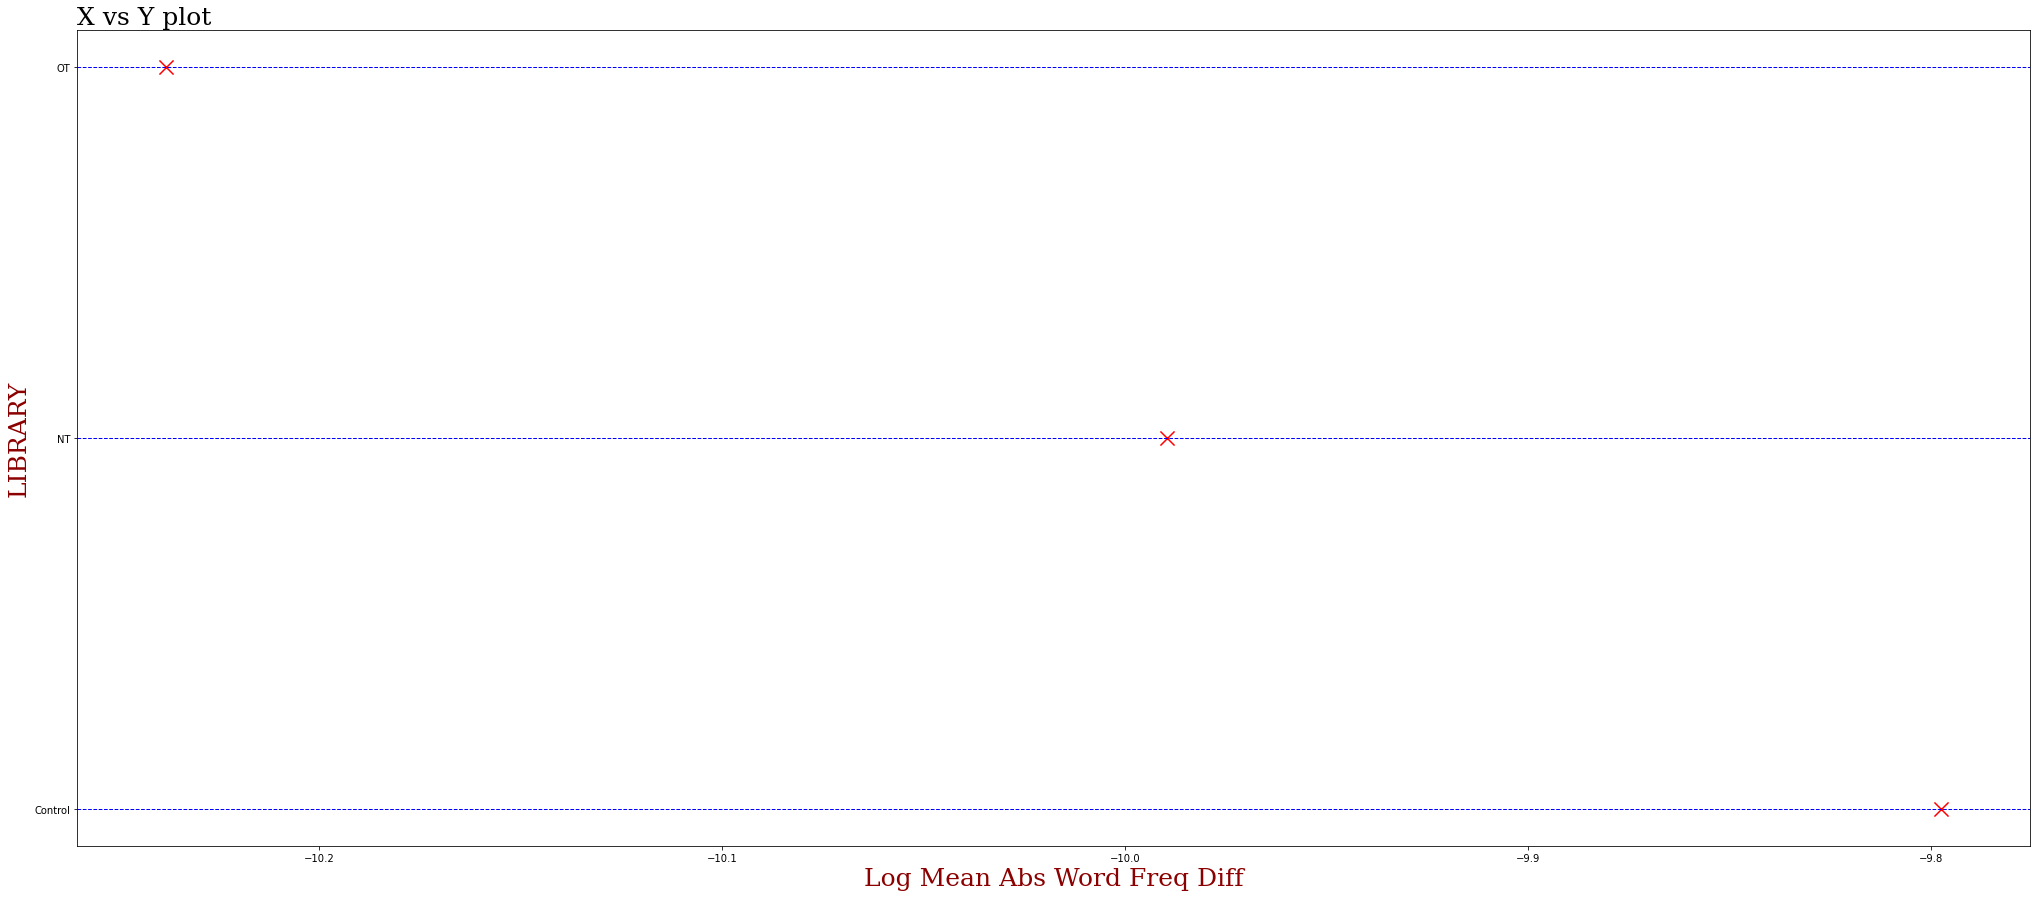

In [6]:
plot_who_vs_LMAWFD(results, df, who='LIBRARY')

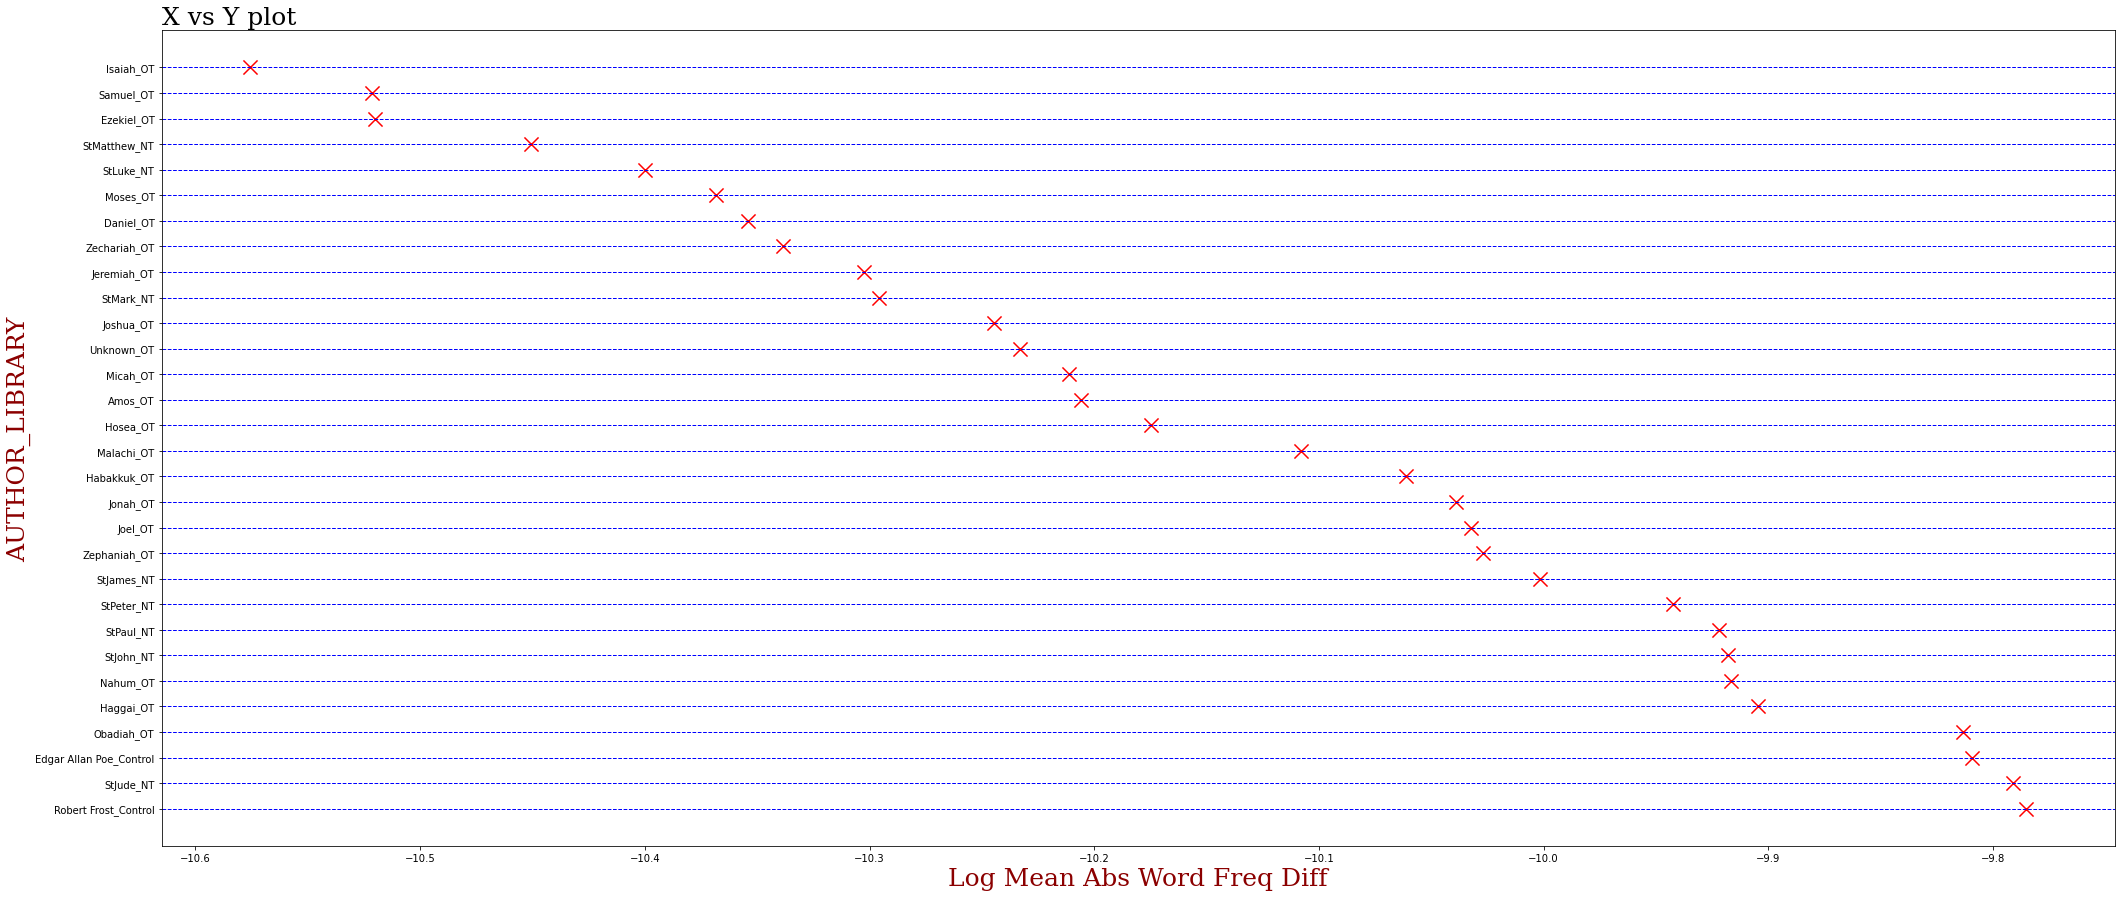

In [7]:
plot_who_vs_LMAWFD(results, df, who='AUTHOR_LIBRARY')

# II. All texts:

In [8]:
results_all = freq_compare_with_Bible_loop(texts='all')
results_all.sample(2)

Comparing all texts...
- Done!


,TEXT,LIBRARY,AUTHOR,TRANSLATION,AUTHOR_LIBRARY,LMAWFD
4,Deuteronomy,OT,Moses,King James,Moses_OT,-10.478771
102,A Valentinian Exposition,NH,Unknown,John D,Unknown_NH,-9.797879


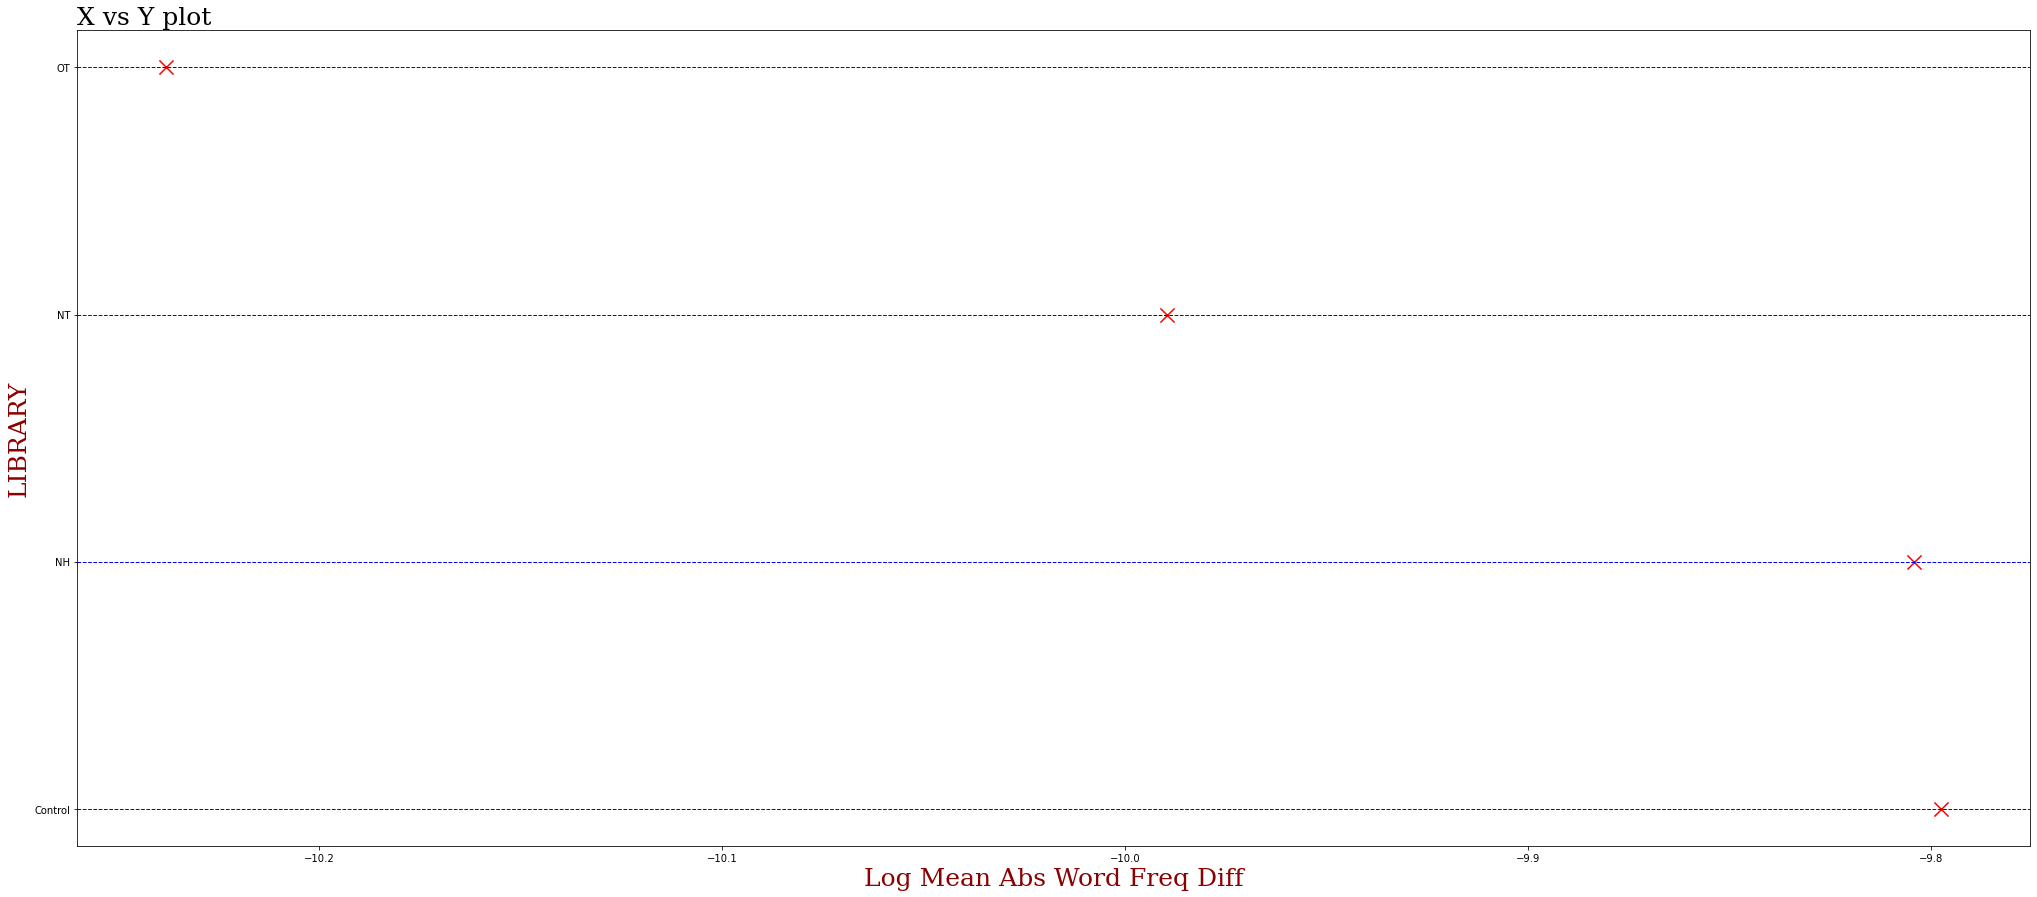

In [9]:
plot_who_vs_LMAWFD(results_all, df, who='LIBRARY')

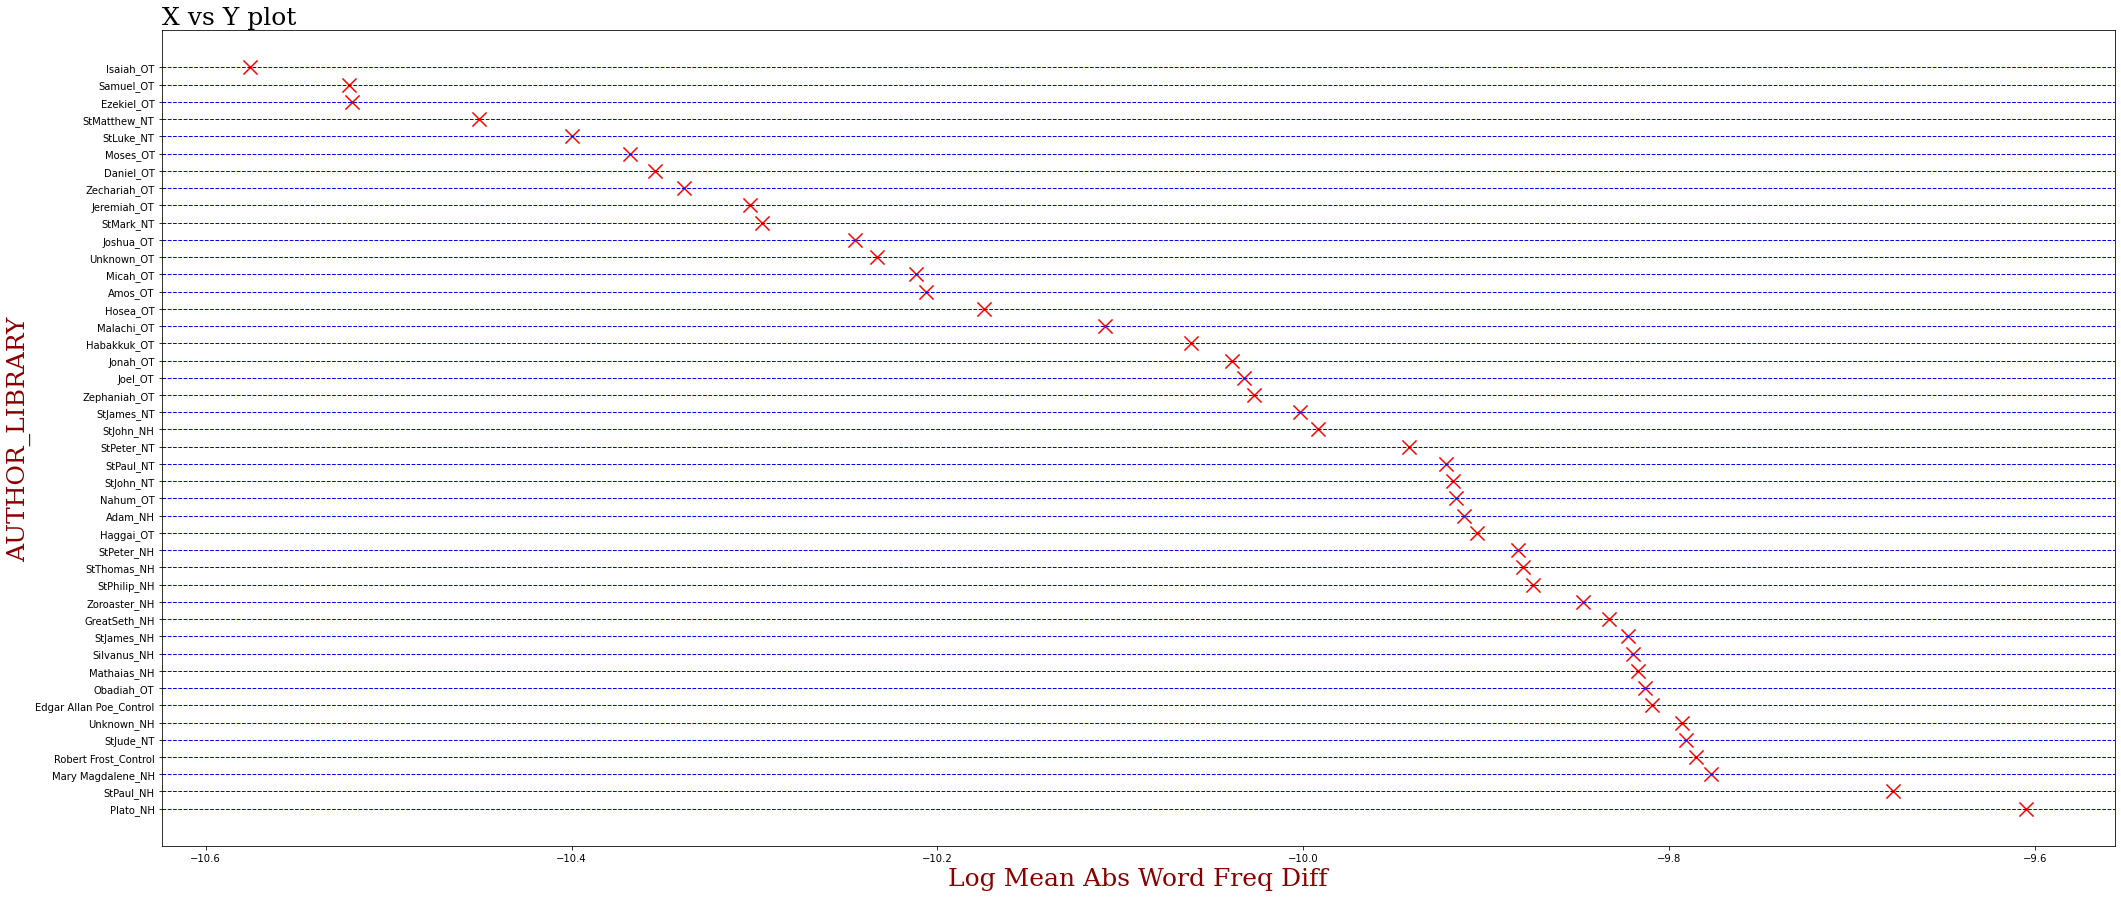

In [10]:
plot_who_vs_LMAWFD(results_all, df, who='AUTHOR_LIBRARY')